In [2]:
import json 
import os
import logging 
import concurrent 
import asyncio 
import re 
import requests 

from collections import deque 
from itertools import chain 

from pprint import PrettyPrinter

from subgrounds import Subgrounds
from palettable.tableau import Tableau_20
from palettable.mycarta import Cube1_4, Cube1_8

from web3 import Web3
from web3.exceptions import ContractLogicError

# apis / networking 
from etherscan import Etherscan
from pycoingecko import CoinGeckoAPI
from dotenv import load_dotenv

import pandas as pd 
import numpy as np 
import altair as alt 


from flywheel_util.constants import (
    addresses, url_subgraphs, colors_24, colors_28, url_subgraphs
) 
from flywheel_util.utils.util import (
    ddf, 
    remove_prefix, 
    query_attrs, 
    camel_to_snake, 
    df_cols_camel_to_snake, 
    df_cols_change_prefix, 
    cg_get_market_history, 
)
from flywheel_util.utils.w3 import (
    verified_contract, 
    get_total_supply_of_erc20,
    get_account_balance_of_erc20, 
    get_erc20_balance_for_all_accounts, 
) 

assert load_dotenv("../../.env") 

# logging.basicConfig(level=logging.INFO)

VALIDATE = True  

pp = PrettyPrinter().pprint

alt.data_transformers.disable_max_rows()
alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

In [3]:
# Setup API clients 
infura_url = f'https://mainnet.infura.io/v3/{os.environ["INFURA_API_KEY"]}'
w3 = Web3(Web3.HTTPProvider(infura_url))
cg = CoinGeckoAPI()
etherscan = Etherscan(os.environ['ETHERSCAN_API_KEY'])

In [4]:
URL_CURVE_POOLS = 'https://api.thegraph.com/subgraphs/name/convex-community/curve-pools'
URL_CURVE_DAO = 'https://api.thegraph.com/subgraphs/name/convex-community/curve-dao'

# Tokens 
addr_frxeth = addresses.token.frxeth
addr_frxethcrv = addresses.token.frxethcrv
addr_frxethcrv_gauge_deposit = addresses.contract.curve.frxethcrv_gauge_deposit
addr_cvxfrxETHCRV = addresses.token.cvxfrxethcrv
addr_frax_farm_frxeth = addresses.contract.frax.farm_frxeth

# Contracts 
addr_convex_base_rewards_pool = addresses.contract.convex.base_reward_pool_cvxfrxethcrv
addr_convex_voter_proxy = addresses.contract.convex.curve_voter_proxy
addr_pool_frxeth_eth = addresses.contract.curve['frxeth-eth']
addr_convex_staking_wrapper_frax = addresses.token['stkcvxfrxethcrv-frax']

# Analysis of Holders of frxETHCRV 

frxETHCRV is the liquidity pool token for the [frxETH:ETH pool](https://curve.fi/#/ethereum/pools/frxeth/deposit) on curve. 

Tracking which users hold frxETHCRV is not as simple as checking the total amount of this token across user accounts. 
There are various platforms where users can stake frxETHCRV in exchange for derivative tokens. This hierarchical outline
shows the various places where the supply of frxETHCRV exists within the ecosystem. 

The following diagram shows how we can break the supply of frxETHCRV into discrete components.

![frxethcrv_supply_breakdown](./assets/frxethcrv_supply_breakdown.png)

In [5]:
def remove_nrows_with_value(df, value, key="account", nrows=1): 
    pre_len = len(df) 
    df = df.loc[df[key].str.lower() != value.lower()]
    assert len(df) == pre_len - nrows 
    return df 

In [6]:
sg = Subgrounds()
sg_curve_pools = sg.load_subgraph(url_subgraphs.convex.curve_pools)
sg_curve_dao = sg.load_subgraph(url_subgraphs.convex.curve_dao) 

In [7]:
def get_curve_gauge_balances(): 
    # frxETHCRV staked in curve gauge by account. frxETHCRV -> frxETHCRV-gauge at 1:1 ratio 
    # ---------------------------------------------------------------------------------------------------------------------
    qattrs = ['id', 'provider', 'value']
    # deposits into gauge 
    df_deposits = query_attrs(
        sg, sg_curve_dao.Query.gaugeDeposits(first=100000, where={'gauge': addr_frxethcrv_gauge_deposit}), qattrs
    )
    df_deposits = remove_prefix(df_deposits, 'gaugeDeposits_') 
    # withdawals from gauge 
    df_withdraws = query_attrs(
        sg, sg_curve_dao.Query.gaugeWithdraws(first=100000, where={'gauge': addr_frxethcrv_gauge_deposit}), qattrs
    )
    df_withdraws = remove_prefix(df_withdraws, 'gaugeWithdraws_') 
    df_withdraws.value *= -1
    # Current deposited amount per address within gauge 
    df_curve = pd.concat([df_deposits, df_withdraws])
    df_curve = df_curve.groupby('provider')['value'].sum().reset_index()
    df_curve = df_curve.loc[df_curve.value != 0].sort_values('value', ascending=False).reset_index(drop=True)
    df_curve['platform'] = 'curve-gauge'
    df_curve.value /= 1e18
    return df_curve 

def validate_curve_gauge_balances(df_curve): 
    frxethCRV_curve_gauge = df_curve.value.sum()
    frxethCRV_curve_gauge_actual = get_account_balance_of_erc20(addr_frxethcrv_gauge_deposit, addr_frxethcrv)

    frxethCRV_convex_staked = df_curve.loc[df_curve.provider == addr_convex_voter_proxy].value.sum()
    frxethCRV_convex_staked_actual = get_account_balance_of_erc20(addr_convex_voter_proxy, addr_frxethcrv_gauge_deposit)

    # Manual validation of frxETHCRV staked in curve gauge 
    # https://etherscan.io/token/0xf43211935c781d5ca1a41d2041f397b8a7366c7a?a=0x2932a86df44fe8d2a706d8e9c5d51c24883423f5
    print(f"Number of frxETHCRV deposited in curve gauge:\n\tComputed: {frxethCRV_curve_gauge:>19}\n\tActual: {frxethCRV_curve_gauge_actual:>21}")
    if VALIDATE: 
        np.testing.assert_almost_equal(frxethCRV_curve_gauge_actual, frxethCRV_curve_gauge, decimal=10)

    # Manual validation of frxETHCRV-gauge (1:1 with frxETHCRV) staked in convex 
    # https://etherscan.io/token/0x2932a86df44fe8d2a706d8e9c5d51c24883423f5?a=0x989aeb4d175e16225e39e87d0d97a3360524ad80
    print(f"Number of frxETHCRV-gauge held by convex voter proxy:\n\tComputed: {frxethCRV_convex_staked:>20}\n\tActual: {frxethCRV_convex_staked_actual:>22}")
    if VALIDATE: 
        np.testing.assert_almost_equal(frxethCRV_convex_staked_actual, frxethCRV_convex_staked, decimal=10)

    print(f"Percent of frxETHCRV staked in curve gauge through convex: {frxethCRV_convex_staked / frxethCRV_curve_gauge:%}")
    df_curve.head()

In [8]:
df_curve = get_curve_gauge_balances()

In [9]:
validate_curve_gauge_balances(df_curve)

Number of frxETHCRV deposited in curve gauge:
	Computed:   81752.90271089817
	Actual:     81752.90271089818
Number of frxETHCRV-gauge held by convex voter proxy:
	Computed:     80629.4459378701
	Actual:       80629.4459378701
Percent of frxETHCRV staked in curve gauge through convex: 98.625790%


In [10]:
def get_convex_staked_balances(): 
    # frxETHCRV staked in convex (curve system). frxETHCRV -> cvxfrxETHCRV at 1:1 ratio 
    # ---------------------------------------------------------------------------------------------------------------------
    qattrs = ['id', 'amount', 'timestamp', 'user.address']
    # deposits into the convex staking contract for curve lp tokens 
    q_deposits = sg_curve_pools.Query.deposits(first=100000, where={'poolid_': {'swap': addr_pool_frxeth_eth}})
    df_deposits = query_attrs(sg, q_deposits, qattrs)
    df_deposits = remove_prefix(df_deposits, 'deposits_') 
    # withdrawals from the convex staking contract for curve lp tokens 
    q_withdrawals = sg_curve_pools.Query.withdrawals(first=100000, where={'poolid_': {'swap': addr_pool_frxeth_eth}})
    df_withdrawals = query_attrs(sg, q_withdrawals, qattrs)
    df_withdrawals = remove_prefix(df_withdrawals, 'withdrawals_') 
    df_withdrawals.amount *= -1
    # current deposited amount per account in convex staking contract for curve lp tokens 
    df_convex = pd.concat([df_deposits, df_withdrawals])
    df_convex = df_convex.groupby('user_address')['amount'].sum().reset_index()
    df_convex = df_convex.loc[df_convex.amount != 0].sort_values('amount', ascending=False).reset_index(drop=True)
    df_convex.amount /= 1e18
    df_convex['platform'] = 'convex-curve'
    df_convex = df_convex.rename(columns={'user_address': 'account'})
    df_convex.head()
    return df_convex 

def validate_convex_staked_balances(df_convex): 
    # Ensure that the holdings of frxETHCRV-gauge by the convex voter proxy address are the same (computed in two ways) 
    # 1. Curve dao subgraph - aggregating curve gauge deposits and withdraws by address (convex voter proxy is one of them). 
    # 2. Convex curve pools subgraph - aggregating convex gauge deposits and withdawals by address. 
    # These numbers should be really close but sometimes might differ due to subgraph indexing speed. 
    convex_frxethcrv_1 = df_curve.loc[df_curve.provider == addr_convex_voter_proxy]['value'].values.tolist()[0]
    convex_frxethcrv_2 = df_convex.amount.sum()
    print(f"Number of frxETHCRV-gauge held by convex voter proxy (curve dao subgraph): {convex_frxethcrv_1:>25}")
    print(f"Number of frxETHCRV-gauge held by convex voter proxy (convex curve pool subgraph): {convex_frxethcrv_2}")
    if VALIDATE: 
        np.testing.assert_almost_equal(convex_frxethcrv_1, convex_frxethcrv_2, 10)

In [11]:
df_convex = get_convex_staked_balances()

In [12]:
validate_convex_staked_balances(df_convex)

Number of frxETHCRV-gauge held by convex voter proxy (curve dao subgraph):          80629.4459378701
Number of frxETHCRV-gauge held by convex voter proxy (convex curve pool subgraph): 80629.44593787008


In [13]:
def get_frax_staked_balances(): 
    # stkfrxETHCRV-frax staked in frax. frxETHCRV -> stkcvxfrxETHCRV-frax
    # ---------------------------------------------------------------------------------------------------------------------
    # These assets are held in the frax farm contract 
    contract_frax_farm = verified_contract(addr_frax_farm_frxeth)
    logs_stake_locked = contract_frax_farm.events.StakeLocked.getLogs(fromBlock=0)
    logs_withdrawals = contract_frax_farm.events.WithdrawLocked.getLogs(fromBlock=0)
    logs_lock_additional = contract_frax_farm.events.LockedAdditional.getLogs(fromBlock=0)
    deposits = [{'account': d.args['user'], 'amount': d.args['amount'] / 1e18} for d in logs_stake_locked + logs_lock_additional]
    withdrawals = [{'account': d.args['user'], 'amount': -d.args['liquidity'] / 1e18} for d in logs_withdrawals]
    # We can determine which addresses correspond to convex staking proxy. These are users who are staking in the frax 
    # farm through convex for boosted FXS yield. 
    abi_convex_staking_proxy = '[{"inputs":[],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[],"name":"FEE_DENOMINATOR","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"_rewardsAddress","type":"address"}],"name":"changeRewards","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"checkpointRewards","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"convexCurveBooster","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"convexDepositToken","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"crv","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"curveLpToken","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"cvx","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"earned","outputs":[{"internalType":"address[]","name":"token_addresses","type":"address[]"},{"internalType":"uint256[]","name":"total_earned","type":"uint256[]"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeRegistry","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"fxs","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"getReward","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bool","name":"_claim","type":"bool"},{"internalType":"address[]","name":"_rewardTokenList","type":"address[]"}],"name":"getReward","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bool","name":"_claim","type":"bool"}],"name":"getReward","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"_owner","type":"address"},{"internalType":"address","name":"_stakingAddress","type":"address"},{"internalType":"address","name":"_stakingToken","type":"address"},{"internalType":"address","name":"_rewardsAddress","type":"address"}],"name":"initialize","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"},{"internalType":"uint256","name":"_addl_liq","type":"uint256"}],"name":"lockAdditional","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"},{"internalType":"uint256","name":"_addl_liq","type":"uint256"}],"name":"lockAdditionalConvexToken","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"},{"internalType":"uint256","name":"_addl_liq","type":"uint256"}],"name":"lockAdditionalCurveLp","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"},{"internalType":"uint256","name":"new_ending_ts","type":"uint256"}],"name":"lockLonger","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"owner","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"poolRegistry","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"rewards","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"_proxy","type":"address"}],"name":"setVeFXSProxy","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_liquidity","type":"uint256"},{"internalType":"uint256","name":"_secs","type":"uint256"}],"name":"stakeLocked","outputs":[{"internalType":"bytes32","name":"kek_id","type":"bytes32"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_liquidity","type":"uint256"},{"internalType":"uint256","name":"_secs","type":"uint256"}],"name":"stakeLockedConvexToken","outputs":[{"internalType":"bytes32","name":"kek_id","type":"bytes32"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"_liquidity","type":"uint256"},{"internalType":"uint256","name":"_secs","type":"uint256"}],"name":"stakeLockedCurveLp","outputs":[{"internalType":"bytes32","name":"kek_id","type":"bytes32"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"stakingAddress","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"stakingToken","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"usingProxy","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"vaultType","outputs":[{"internalType":"enum IProxyVault.VaultType","name":"","type":"uint8"}],"stateMutability":"pure","type":"function"},{"inputs":[],"name":"vaultVersion","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"pure","type":"function"},{"inputs":[],"name":"vefxsProxy","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"}],"name":"withdrawLocked","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bytes32","name":"_kek_id","type":"bytes32"}],"name":"withdrawLockedAndUnwrap","outputs":[],"stateMutability":"nonpayable","type":"function"}]'
    vault_owners = {}
    for d in deposits:
        a = d['account']
        is_contract_account = True if w3.eth.getCode(Web3.toChecksumAddress(a)) else False
        if is_contract_account: 
            try: 
                contract = w3.eth.contract(Web3.toChecksumAddress(a), abi=abi_convex_staking_proxy)
                owner = contract.functions.owner().call()
                vault_owners[a] = owner
            except ContractLogicError: 
                pass 
    # During this groupby, accounts / vaults owned by accounts are still separate bc we haven't mapped them yet 
    df_frax_farm = pd.DataFrame(deposits + withdrawals).groupby('account')['amount'].sum().reset_index()
    df_frax_farm = df_frax_farm.loc[df_frax_farm.amount != 0]
    df_frax_farm['vault_address'] = df_frax_farm.account.apply(lambda a: a if a in vault_owners else None)
    vault_mask = ~df_frax_farm.vault_address.isna()
    df_frax_farm.loc[vault_mask, 'account'] = df_frax_farm.loc[vault_mask].account.apply(lambda a: vault_owners[a])
    df_frax_farm['platform'] = 'frax-farm'
    df_frax_farm.loc[~df_frax_farm.vault_address.isna(), 'platform'] = 'frax-farm-convex'
    return df_frax_farm 

In [14]:
df_frax_farm = get_frax_staked_balances()

/opt/miniconda3/envs/flywheel-testing/lib/python3.10/site-packages/web3/method.py:215: DeprecationWarning: getCode is deprecated in favor of get_code
  warnings.warn(


In [15]:
df_circ_frxETHCRV = get_erc20_balance_for_all_accounts(addr_frxethcrv, 0)
df_circ_frxETHCRV = remove_nrows_with_value(df_circ_frxETHCRV, addr_frxethcrv_gauge_deposit) 
df_circ_frxETHCRV = df_circ_frxETHCRV.rename(columns={'value': 'frxETHCRV (circulating)'})

In [16]:
df_circ_cvxfrxETHCRV = get_erc20_balance_for_all_accounts(addr_cvxfrxETHCRV, 0)
df_circ_cvxfrxETHCRV = remove_nrows_with_value(df_circ_cvxfrxETHCRV, addr_convex_base_rewards_pool)
df_circ_cvxfrxETHCRV = df_circ_cvxfrxETHCRV.rename(columns={'value': 'cvxfrxETHCRV (circulating)'})

In [17]:
df_circ_stkcvxfrxETHCRV_frax = get_erc20_balance_for_all_accounts(addr_convex_staking_wrapper_frax, 0)
df_circ_stkcvxfrxETHCRV_frax = remove_nrows_with_value(df_circ_stkcvxfrxETHCRV_frax, addr_frax_farm_frxeth)
df_circ_stkcvxfrxETHCRV_frax = df_circ_stkcvxfrxETHCRV_frax.rename(columns={'value': 'stkcvxfrxETHCRV-frax (circulating)'})

In [18]:
df_curve_staking = remove_nrows_with_value(df_curve, addr_convex_voter_proxy, key='provider') 
df_curve_staking = (
    df_curve_staking.rename(columns={'provider': 'account', 'value': 'frxETHCRV-gauge (staked directly through curve)'})
    .drop(columns=['platform'])
) 
# df_curve_staking.head(1)

In [19]:
df_convex_staking = remove_nrows_with_value(df_convex, addr_convex_staking_wrapper_frax, key='account') 
df_convex_staking = (
    df_convex_staking.rename(columns={'amount': 'cvxfrxETHCRV (staked on convex curve system)'})
    .drop(columns=['platform'])
) 
# df_convex_staking.head(1)

In [20]:
df_frax_frax = df_frax_farm.loc[df_frax_farm.platform == 'frax-farm']
df_frax_convex = df_frax_farm.loc[df_frax_farm.platform == 'frax-farm-convex']
df_frax_frax = df_frax_frax.rename(columns={'amount': 'stkcvxfrxETHCRV-frax (staked on frax)'})
df_frax_convex = df_frax_convex.rename(columns={'amount': 'stkcvxfrxETHCRV-frax (staked on convex frax system)'})
df_frax_staking = (
    df_frax_frax.drop(columns=["platform", 'vault_address'])
    .merge(
        df_frax_convex.drop(columns=["platform", 'vault_address']) , how='outer', on='account'
    )
    .fillna(0)
)
# df_frax_staking.head()

In [21]:
dfs = [
    df_curve_staking, 
    df_convex_staking, 
    df_frax_staking, 
    df_circ_frxETHCRV, 
    df_circ_cvxfrxETHCRV, 
    df_circ_stkcvxfrxETHCRV_frax, 
]
for i in range(len(dfs)): 
    dfs[i] = dfs[i].set_index('account') 
df = pd.concat(dfs, axis=1).fillna(0)
value_cols = [c for c in df.columns if c != 'account']
df['total_frxETHCRV'] = df[value_cols].sum(axis=1)
df = df.loc[df.total_frxETHCRV != 0]
df = df.sort_values('total_frxETHCRV', ascending=False).reset_index()

In [22]:
actual = get_total_supply_of_erc20(addr_frxethcrv)
computed = df.total_frxETHCRV.sum()
print(f"Total Supply frxETHCRV (actual): {actual:>21}")
print(f"Total Supply frxETHCRV (computed): {computed:>20}")
print("-" * 80)
for c in sorted(value_cols): 
    print(f"{c:<55}{df[c].sum()}")

Total Supply frxETHCRV (actual):      81818.5093869991
Total Supply frxETHCRV (computed):    81818.50938699908
--------------------------------------------------------------------------------
cvxfrxETHCRV (circulating)                             0.0
cvxfrxETHCRV (staked on convex curve system)           2365.544964770673
frxETHCRV (circulating)                                65.60667610090428
frxETHCRV-gauge (staked directly through curve)        1123.4567730280828
stkcvxfrxETHCRV-frax (circulating)                     633.6111053832553
stkcvxfrxETHCRV-frax (staked on convex frax system)    76653.27178004783
stkcvxfrxETHCRV-frax (staked on frax)                  977.0180876683514


/opt/miniconda3/envs/flywheel-testing/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


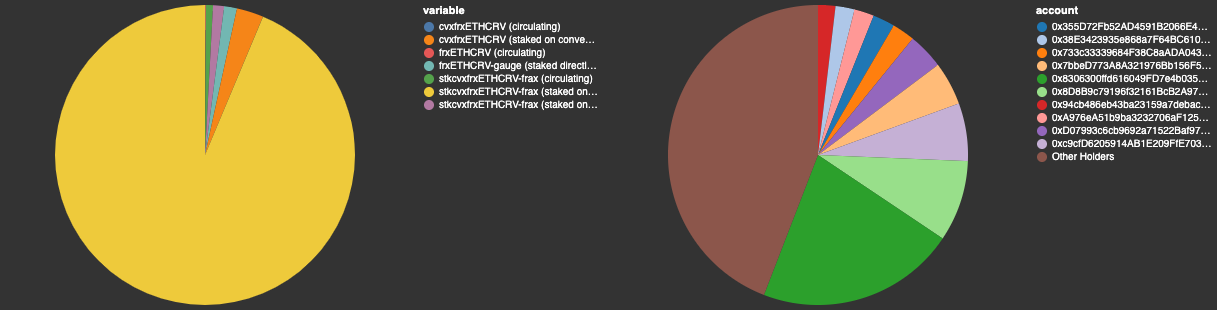

In [23]:
d = df.reset_index()[['index', 'account', 'total_frxETHCRV']].reset_index()
top_n_holders = 10
d_top_n = (
    pd.concat([
        d.loc[d.index < top_n_holders][['account', 'total_frxETHCRV']].rename(columns={'total_frxETHCRV': 'frxETHCRV'}), 
        pd.DataFrame([{
            "account": "Other Holders", 
            "frxETHCRV": d.loc[d.index >= top_n_holders].total_frxETHCRV.sum()}
        ])
    ])
    .sort_values('frxETHCRV').reset_index(drop=True).reset_index()
)

c = (
    alt.hconcat(
        alt.Chart(
            pd.melt(df, id_vars='account', value_vars=value_cols).reset_index()
            .groupby('variable')['value'].sum().reset_index()
            .sort_values('value').reset_index(drop=True).reset_index()
        )
        .transform_joinaggregate(amount_total="sum(value)")
        .transform_calculate(fraction="datum.value / datum.amount_total")
        .mark_arc()
        .encode(
            theta="value:Q", 
            color="variable:N", 
            order="index:O", 
            tooltip=[
                alt.Tooltip("variable:N"), 
                alt.Tooltip("value:Q", format=",d", title="frxETHCRV"),
                alt.Tooltip("fraction:Q", format=".1%", title="Share"),
            ]
        ),
        alt.Chart(d_top_n)
        .transform_joinaggregate(total="sum(frxETHCRV)")
        .transform_calculate(fraction="datum.frxETHCRV / datum.total")
        .mark_arc()
        .encode(
            theta=alt.Theta("frxETHCRV:Q"), 
            color=alt.Color("account:N", scale=alt.Scale(range=colors_28)), 
            order="index:O", 
            tooltip=[
                alt.Tooltip("account:N"), 
                alt.Tooltip("frxETHCRV:Q", format=",d", title="frxETHCRV"),
                alt.Tooltip("fraction:Q", format=".1%", title="Share"),
            ]
        ) 
    )
    .resolve_scale(color="independent")
    .resolve_legend(color="independent")
)
c

In [24]:
precision = 2
pd.set_option('display.float_format', lambda x: f'%.{precision}f' % x)

# labeling some large wallets. TODO: automate this later on. 
ens = {
    "0x9026A229b535ecF0162Dfe48fDeb3c75f7b2A7AE": "czsamsunsb.eth", 
    "0x2dE9D6f84e28F3A347b97C6a3Db51D366E65bA4C": "safefarmer.eth", 
    "0x2f206D74d7cFcc6a9F556825034eB110a572AD62": "uhtearyum.eth", 
    "0xB29Cd9C87a624B940335d6d5e1D4aADf7D95bEeC": "adamant.eth", 
}
df['ens'] = df.account.apply(lambda a: ens.get(a))
df = df.sort_values('total_frxETHCRV', ascending=False).reset_index(drop=True) 

ddf(
    df.loc[df.total_frxETHCRV >= 10**(-1*precision)].head(10)
)

,account,frxETHCRV-gauge (staked directly through curve),cvxfrxETHCRV (staked on convex curve system),stkcvxfrxETHCRV-frax (staked on frax),stkcvxfrxETHCRV-frax (staked on convex frax system),frxETHCRV (circulating),cvxfrxETHCRV (circulating),stkcvxfrxETHCRV-frax (circulating),total_frxETHCRV,ens
0,0x8306300ffd616049FD7e4b0354a64Da835c1A81C,0.00,0.00,0.00,17569.21,0.00,0.00,0.00,17569.21,None
1,0x8D8B9c79196f32161BcB2A9728D274B3b45eB9AF,0.00,0.00,0.00,7154.86,0.00,0.00,0.00,7154.86,None
2,0xc9cfD6205914AB1E209FfE70326d8dd15fc58187,0.00,0.00,0.00,5097.31,1.05,0.00,0.00,5098.36,None
3,0x7bbeD773A8A321976Bb156F57E0846368Bd9C9d7,0.00,0.00,0.00,3821.93,0.00,0.00,0.00,3821.93,None
4,0xD07993c6cb9692a71522Baf970A31069034dF2B0,0.00,0.00,0.00,3170.97,0.00,0.00,0.00,3170.97,None
5,0x733c33339684F38C8aADA0434751611e168255c4,0.00,0.00,0.00,1999.26,0.00,0.00,0.00,1999.26,None
6,0x355D72Fb52AD4591B2066E43e89A7A38CF5cb341,0.00,0.00,0.00,1943.53,0.00,0.00,0.00,1943.53,None
7,0xA976eA51b9ba3232706aF125a92e32788Dc08Ddc,0.00,0.00,0.00,1744.71,0.00,0.00,0.00,1744.71,None
8,0x38E3423935e868a7F64BC610A4A756Bd27AbacB7,0.00,0.00,0.00,1676.43,0.00,0.00,0.00,1676.43,None
9,0x94cb486eb43ba23159a7debac920b0fa7cb476fa,0.00,1531.17,0.00,0.00,0.00,0.00,0.00,1531.17,None


In [25]:
# # - total FrxETH/sfrxeth volume 
# from subgrounds import Subgrounds

# sg = Subgrounds()
# sg_curve_vol = sg.load_subgraph(url_subgraphs.convex.curve_vol_mainnet)
# q = sg_curve_vol.Query.swapVolumeSnapshots(where={"pool": "0xa1f8a6807c402e4a15ef4eba36528a3fed24e577"}, first=1000)
# df_frxeth_pool = sg.query_df([q.timestamp, q.volumeUSD])
# df_frxeth_pool = remove_prefix(df_frxeth_pool, 'swapVolumeSnapshots_')
# df_frxeth_pool.timestamp = pd.to_datetime(df_frxeth_pool.timestamp, unit='s')
# df_frxeth_pool['date'] = pd.to_datetime(df_frxeth_pool.timestamp.dt.date)
# df_frxeth_pool = df_frxeth_pool.groupby("date").max().reset_index()[['date', 'volumeUSD']]
# df_frxeth_pool.volumeUSD /= 2
# print(df_frxeth_pool.volumeUSD.sum()) 
# alt.Chart(df_frxeth_pool).mark_line().encode(x="date:T", y="volumeUSD:Q")

In [26]:
# addrs = [
#     '0x9026A229b535ecF0162Dfe48fDeb3c75f7b2A7AE', # (czsamsunsb.eth)
#     '0xD07993c6cb9692a71522Baf970A31069034dF2B0',
#     '0x581cf4642283edA85a64bB45cd226854415AB830',
# ] 

In [27]:
# qattrs = ['id', 'amount', 'timestamp', 'user.address']
# # deposits into the convex staking contract for curve lp tokens 
# q_deposits = sg_curve_pools.Query.deposits(first=100000, where={'poolid_': {'swap': addr_pool_frxeth_eth}})
# df_deposits = query_attrs(sg, q_deposits, qattrs)
# df_deposits = remove_prefix(df_deposits, 'deposits_') 
# df_deposits.timestamp = pd.to_datetime(df_deposits.timestamp, unit='s')
# # current deposited amount per account in convex staking contract for curve lp tokens 
# # df_convex = pd.concat([df_deposits, df_withdrawals])
# # df_convex = df_convex.groupby('user_address')['amount'].sum().reset_index()
# # df_convex = df_convex.loc[df_convex.amount != 0].sort_values('amount', ascending=False).reset_index(drop=True)
# # df_convex.amount /= 1e18
# # df_convex['platform'] = 'convex-curve'
# # df_convex = df_convex.rename(columns={'user_address': 'account'})
# # df_convex.head()
# # return df_convex 